# Global Research Keyword Analysis 

In [1]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import folium
from folium import plugins
import ast
from collections import Counter
from IPython.display import IFrame, display
import re
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import requests
import branca
from branca.element import Template, MacroElement
import numpy as np
import io
from PIL import Image
from collections import defaultdict

# Load dataset and drop nulls in critical columns
df = pd.read_csv('../FINAL_ARXIV_2025_with_affiliations.csv')
# df = df.dropna(subset=['affiliations', 'keywords', 'smart_keywords'])

coords_df = pd.read_csv('../world_coords.csv')

# GeoJSON URL for country boundaries
political_countries_url = "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"

plt.style.use('dark_background')
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams.update({'figure.dpi': 150})

def display_html(location: str):
    from IPython.display import HTML
    from IPython.display import IFrame
    import base64
    with open(location, "r") as f:
        html_content = f.read()
    
    html_str = "data:text/html;base64," + base64.b64encode(html_content.encode('utf-8')).decode('utf-8')
    display(IFrame(src=html_str, width='100%', height='500px'))

def saving_plot(map, filename):
    img_data = map._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    img.save(filename)


In [2]:
# Robust Country Extraction and Keyword Cleaning
def extract_country_from_affil(affil_str):
    if not isinstance(affil_str, str) or not affil_str:
        return None
    
    country_map = {
        'usa': 'United States',
        'united states': 'United States',
        'uk': 'United Kingdom',
        'united kingdom': 'United Kingdom',
        'china': 'China',
        "people's republic of china": 'China',
        'germany': 'Germany',
        'france': 'France',
        'italy': 'Italy',
        'india': 'India',
        'japan': 'Japan',
        'canada': 'Canada',
        'australia': 'Australia',
        'spain': 'Spain',
        'russia': 'Russia',
        'brazil': 'Brazil',
        'south korea': 'South Korea',
        'switzerland': 'Switzerland',
        'netherlands': 'Netherlands',
        'sweden': 'Sweden',
        'taiwan': 'Taiwan',
        'israel': 'Israel',
        'austria': 'Austria',
        'denmark': 'Denmark',
        'belgium': 'Belgium',
        'finland': 'Finland',
        'norway': 'Norway',
        'poland': 'Poland',
        'mexico': 'Mexico',
        'chile': 'Chile',
        'argentina': 'Argentina',
        'czech republic': 'Czech Republic',
        'turkey': 'Turkey',
        'greece': 'Greece',
        'portugal': 'Portugal',
        'singapore': 'Singapore',
        'south africa': 'South Africa',
        'hong kong': 'Hong Kong',
        'new zealand': 'New Zealand',
        'ireland': 'Ireland',
        'hungary': 'Hungary',
        'colombia': 'Colombia'
    }
    
    parts = [p.strip().lower() for p in affil_str.split(',')]
    for part in reversed(parts):
        clean_part = re.sub(r'[^a-zA-Z\s]', '', part).strip()
        if clean_part in country_map:
            return country_map[clean_part]
    
    affil_lower = affil_str.lower()
    for key, val in country_map.items():
        if key in affil_lower:
            return val
            
    return None

def process_affiliations(row):
    try:
        aff_raw = row['affiliations']
        affs = aff_raw.split(';') if ';' in aff_raw else [aff_raw]
        extracted_countries = []
        for aff in affs:
            country = extract_country_from_affil(aff)
            if country:
                extracted_countries.append(country)
        return list(set(extracted_countries))
    except:
        return []

def clean_keyword(k):
    # Remove things like "(573)" from "Galaxies (573)"
    s = re.sub(r'\s*\(\d+\)\s*$', '', str(k)).strip()
    # Filter out email addresses
    if '@' in s:
        return None
    return s

df['countries_extracted'] = df.apply(process_affiliations, axis=1)


In [3]:
# Aggregation and Coloring Functions
def get_country_top_keywords(df, col_name):
    country_keywords = {}
    for _, row in df.iterrows():
        try:
            countries = row['countries_extracted']
            # Parse keywords
            raw_keywords = ast.literal_eval(row[col_name])
            cleaned_keywords = [clean_keyword(k) for k in raw_keywords if k]
            cleaned_keywords = [k for k in cleaned_keywords if k] # Filter None
            
            if not countries or not cleaned_keywords: continue
            
            for country in countries:
                if country not in country_keywords:
                    country_keywords[country] = Counter()
                country_keywords[country].update(cleaned_keywords)
        except:
            continue
            
    results = {}
    all_top_keywords = set()
    for country, counts in country_keywords.items():
        most_common = counts.most_common(5)
        if most_common:
            results[country] = most_common
            all_top_keywords.add(most_common[0][0])
            
    return results, sorted(list(all_top_keywords))

def create_legend_html(keyword_colors, title):
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: auto; 
                border:2px solid grey; z-index:9999; font-size:12px;
                background-color:white; opacity: 0.9; padding: 10px; max-height: 400px; overflow-y: auto;">
    <b>{title}</b><br>
    '''
    for kw, color in keyword_colors.items():
        legend_html += f'<i style="background:{color}; width:12px; height:12px; float:left; margin-right:5px; border: 1px solid black;"></i>{kw}<br>'
    legend_html += '</div>'
    return legend_html

def generate_keyword_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            
            # folium.CircleMarker(
            #     location=[lat, lon],
            #     radius=4,
            #     color='black',
            #     weight=1,
            #     fill=True,
            #     fill_color=keyword_colors.get(top_kw, 'white'),
            #     fill_opacity=1,
            #     popup=f"<b>{country}</b><br>Top Keyword: {top_kw}<br>Total Keywords:<br>" + "<br>".join([f"{k}: {c}" for k, c in top_kws])
            # ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m


## Map 1: Top Keywords per Country (All Authors)

In [4]:
# Generate Map 1: Most Frequent Keywords
print("Processing keywords column...")
kw_results, unique_kws = get_country_top_keywords(df, 'keywords')
k_map =generate_keyword_map(kw_results, unique_kws, "Top Research Keywords", "global_keywords_map.html")
saving_plot(k_map, "./plots/keyword_map.png")

Processing keywords column...


C:\Users\hetan\AppData\Local\Temp\ipykernel_22348\2647494108.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


## Map 2: Top Smart Keywords per Country (All Authors)

In [5]:
# Generate Map 2: Most Frequent Smart Keywords
print("Processing smart_keywords column...")
skw_results, unique_skws = get_country_top_keywords(df, 'smart_keywords_2')
k2_map =generate_keyword_map(skw_results, unique_skws, "Top Smart Keywords", "global_smart_keywords_map.html")
k2_map =saving_plot(k2_map, "./plots/smart_keyword_map.png")

Processing smart_keywords column...


C:\Users\hetan\AppData\Local\Temp\ipykernel_22348\2647494108.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Telescopes

Use `masked_data` dataframe to see the telescope map

In [6]:
#telescope_citation_analysis.csv
from PIL import Image
jwst_img = Image.open('../Images/james-webb-space-telescope-graphic-illustration-astronomy-vector.jpg')
gaia_img = Image.open('../Images/images.jpeg')
alma_img = Image.open('../Images/alma-features.png')
tess_img = Image.open('../Images/tess-telescope.png')
integral_img = Image.open('../Images/INTEGRAL_spacecraft_model.png')
fermi_img = Image.open('../Images/Fermi_Gamma-ray_Space_Telescope_spacecraft_model.png')
sdss_img = Image.open('../Images/SDSS_telescope.png')
lisa_img = Image.open('../Images/Lisa_logo-mission-patch-1024x1024.jpg')
lsst_img = Image.open('../Images/Large_Synoptic_Survey_Telescope_3_4_render_2013.png')
newton_img = Image.open('../Images/XMM-Newton_spacecraft_model.png')

image_list = {
    'JWST': jwst_img,
    'GAIA': gaia_img,
    'ALMA': alma_img,
    'TESS': tess_img,
    'INTEGRAL': integral_img,
    'Fermi': fermi_img,
    'SDSS': sdss_img,
    'LISA': lisa_img,
    'LSST': lsst_img,
    'XMM-Newton': newton_img,
}

In [7]:
print(df['published_journal'].notna().sum())

1148


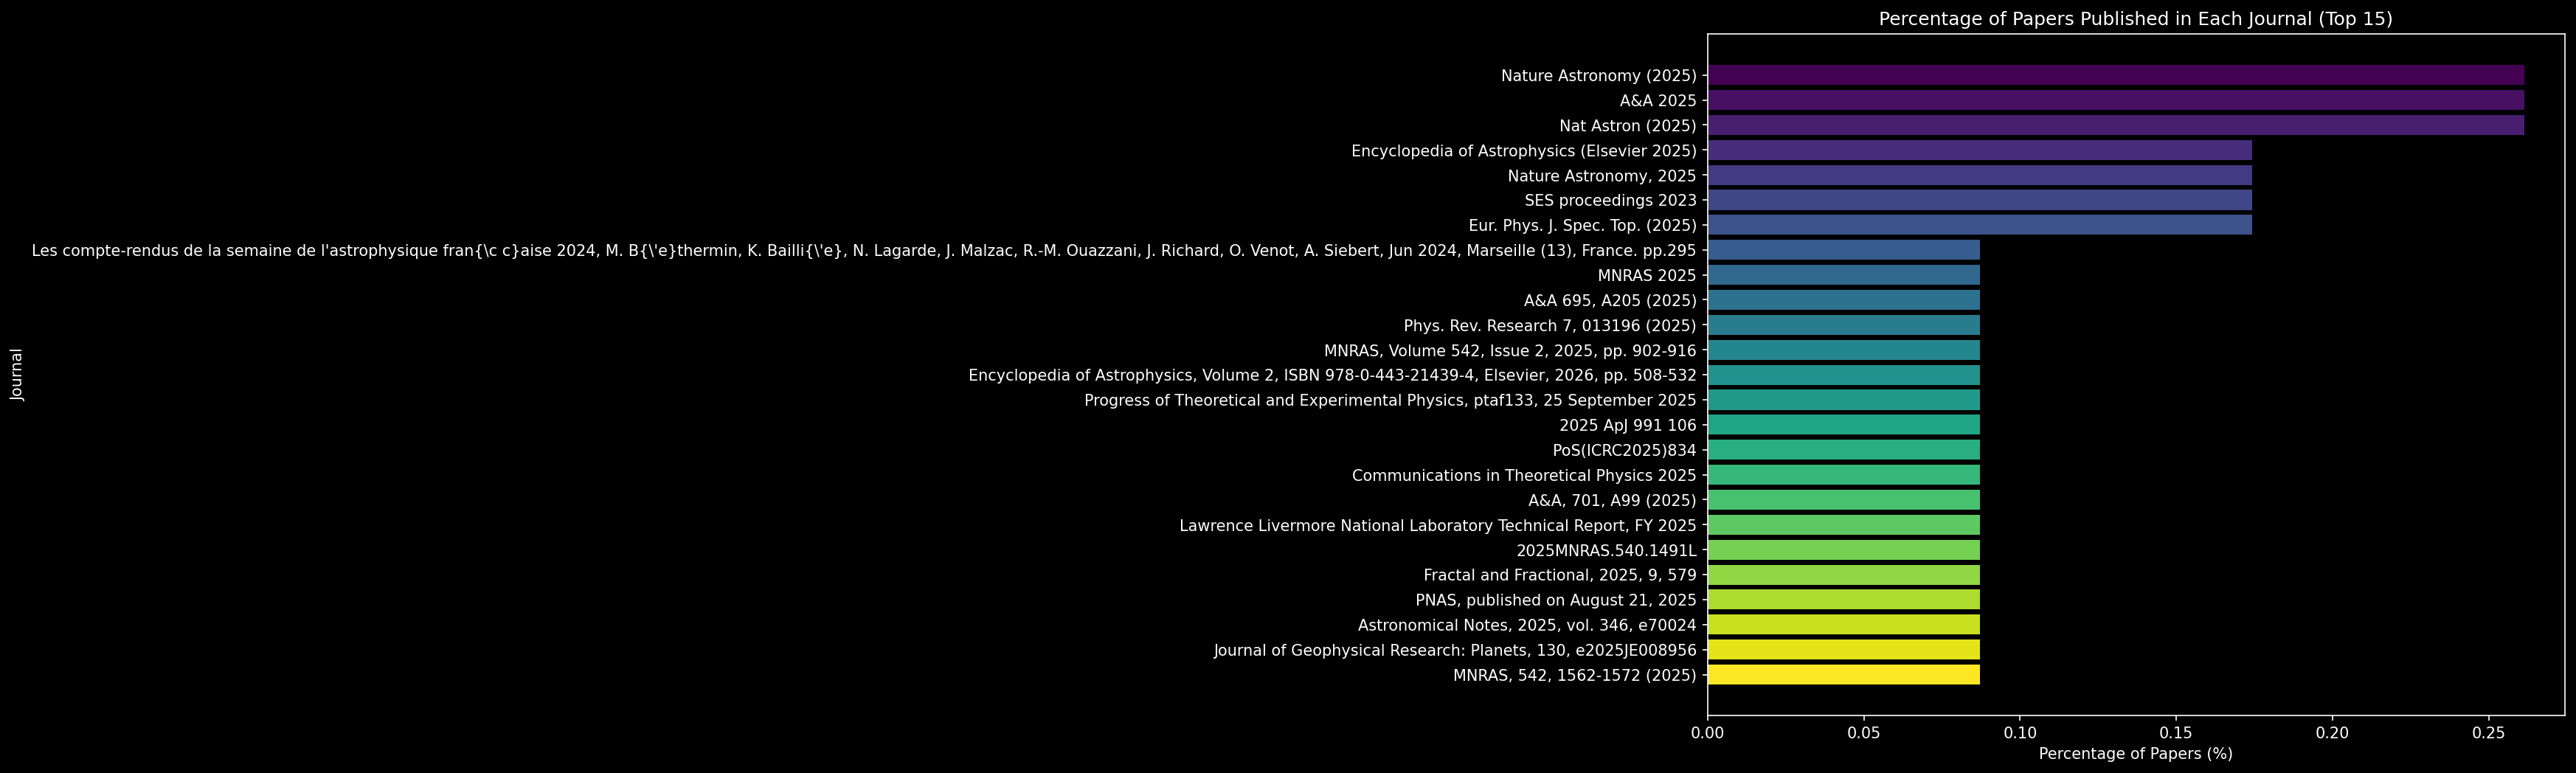

In [8]:
journal_counts = df['published_journal'].value_counts(normalize=True).head(25) * 100
plt.figure(figsize=(10, 8))
plt.barh(journal_counts.index, journal_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(journal_counts))))
plt.xlabel('Percentage of Papers (%)')
plt.ylabel('Journal')
plt.title('Percentage of Papers Published in Each Journal (Top 15)')
plt.gca().invert_yaxis()
plt.show()

In [9]:
list_of_telescopes = [
    'HST',
    'CSST',
    'Chandra',
    'Spitzer',
    'JWST',
    'VLT',
    'ALMA',
    'Keck',
    'Subaru',
    'Euclid',
    'Vera C. Rubin Observatory',
    'SDSS',
    'GAIA',
    'ZWICKY',
    'LIGO',
    'LISA',
    'Fermi',
    'Swift',
    'TESS',
    'NICER',
    'NuSTAR',
    'XMM-Newton',
    'INTEGRAL',
    'SPHEREx',
    'SVOM',
    'AstroSat',
    'HXMT',
    'XRISM',
    'Einstein Probe',
    'IXPE',
    'XPoSat',
    'IRIS',
    'CUTE',
    'GLIDE',
    'NEOSSat',
    'CHEOPS',
    'DAMPE',
    'CALCET',
    'LSST',
]

long_names = {
    'HST': 'Hubble Space Telescope',
    'CSST': 'China Space Station Telescope',
    'JWST': 'James Webb Space Telescope',
    'VLT': 'Very Large Telescope',
    'ALMA': 'Atacama Large Millimeter/submillimeter Array',
    'SDSS': 'Sloan Digital Sky Survey',
    'LIGO': 'Laser Interferometer Gravitational-Wave Observatory',
    'LISA': 'Laser Interferometer Space Antenna',
    'ZWICKY': 'Zwicky Transient Facility',
    'Chandra': 'Chandra X-ray Observatory',
    'Spitzer': 'Spitzer Space Telescope',
    'Fermi': 'Fermi Gamma-ray Space Telescope',
    'Swift': 'Neil Gehrels Swift Observatory',
    'TESS': 'Transiting Exoplanet Survey Satellite',
    'NICER': 'Neutron star Interior Composition Explorer',
    'GAIA': 'Global Astrometric Interferometer for Astrophysics',
    'NuSTAR': 'Nuclear Spectroscopic Telescope Array',
    'XMM-Newton': 'X-ray Multi-Mirror Mission - Newton',
    'INTEGRAL': 'INTErnational Gamma-Ray Astrophysics Laboratory',
    'SPHEREx': 'Spectro-Photometer for the History of the Universe, Epoch of Reionization, and Ices Explorer',
    'SVOM': 'Space-based multi-band astronomical Variable Objects Monitor',
    'AstroSat': 'AstroSat Space Observatory',
    'HXMT': 'Hard X-ray Modulation Telescope',
    'XRISM': 'X-ray Imaging and Spectroscopy Mission',
    'Einstein Probe': 'Einstein Probe X-ray Observatory',
    'IXPE': 'Imaging X-ray Polarimetry Explorer',
    'XPoSat': 'X-ray Polarimeter Satellite',
    'IRIS': 'Interface Region Imaging Spectrograph',
    'CUTE': 'Colorado Ultraviolet Transit Experiment',
    'GLIDE': 'Carruthers Geocorona Observatory',
    'NEOSSat': 'Near-Earth Object Surveillance Satellite',
    'CHEOPS': 'Characterising Exoplanet Satellite',
    'DAMPE': 'DArk Matter Particle Explorer',
    'CALCET': 'CALorimetric Electron Telescope',
    'RST': 'Roman Space Telescope',
    'RST': 'Nancy Grace Roman Space Telescope',
    'Vera Rubin': 'Vera C. Rubin Observatory',
    'Rubin': 'Vera C. Rubin Observatory',
    'Vera Rubin': 'LSST',
    'Vera Rubin': 'Legacy Survey of Space and Time',
}


df['telescope'] = np.nan                       # make sure column exists
for idx in df.index:                             # use real index labels
    for col in ('title', 'abstract'):
        txt = df.at[idx, col]
        if isinstance(txt, str):
            for tel in list_of_telescopes:
                if tel.lower() in txt.lower():
                    df.at[idx, 'telescope'] = tel
                    break                        # first match wins

C:\Users\hetan\AppData\Local\Temp\ipykernel_22348\439180736.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'INTEGRAL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'telescope'] = tel


In [10]:
mask = df['telescope'].notna()
masked_data = df[mask]
masked_data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,countries_extracted,telescope
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],[Italy],INTEGRAL
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...",[],Fermi
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,[China],ALMA
9,IXPE observations of supernova remnants,Supernova remnants (SNRs) are among the most i...,['Riccardo Ferrazzoli'],9.0,14.0,1.0,arxiv.org/pdf/2501.12719,High Energy Astrophysical Phenomena,NaN,appear in the Proceedings of the 17th Marcel G...,...,0,"Ferrazzoli, Riccardo: INAF",0.0,0.0,1,1,"['Cosmic ray objects', 'Cosmic ray sources', '...",[],[],IXPE
14,A Pilot Study for the CSST Slitless Spectrosco...,The wide survey of the Chinese Space Station T...,"['Yuxuan Pang', 'Xue-Bing Wu', 'Yuming Fu', 'R...",15.0,19.0,5.0,arxiv.org/pdf/2501.12665,Astrophysics of Galaxies,NaN,NaN,...,0,"Pang, Yuxuan: Department of Astronomy, School ...",1.0,0.0,1,1,"['A stars', 'AB magnitude', 'AGN']",['Active galactic nuclei (16) — Galactic and e...,"[Netherlands, China]",CSST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18322,Evolving and interacting dark energy: photomet...,We investigate the Dark Scattering (DS) intera...,"['M. Tsedrik', 'B. Bose']",6.0,9.0,2.0,arxiv.org/pdf/2512.17684,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['CMB', 'Cosmological models', 'Cosmological p...",['cosmology: theory – cosmology: dark energy –...,[],Euclid
18326,Interpreting the strong clustering of ultra-di...,We use the IllustrisTNG300-ODM simulation to i...,"['Qinglin Ma', 'Cheng Li', 'Yangyao Chen', 'Ho...",8.0,11.0,0.0,arxiv.org/pdf/2512.17742,Astrophysics of Galaxies,NaN,NaN,...,0,NaN,0.0,0.0,0,1,"['A dwarfs', 'B dwarfs', 'Clustering']",['galaxies: evolution – galaxies: formation – ...,[],SDSS
18330,Selected topics on: 1) proposal of interpretin...,As the fiftieth anniversary of our common effo...,"['R. Ruffini', 'C. Sigismondi', 'Y. Wang', 'J....",35.0,46.0,1.0,arxiv.org/pdf/2512.17787,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['Dark energy', 'Dark matter', 'Field of view']",['Compact objects'],[],Fermi
18331,Systematic search of laser and phase modulatio...,Heterodyne interferometry for precision scienc...,"['Kohei Yamamoto', 'Olaf Hartwig', 'Lennart Wi...",8.0,24.0,0.0,arxiv.org/pdf/2512.17802,Instrumentation and Methods for Astrophysics,"['Applied Physics', 'Optics']",NaN,...,0,NaN,0.0,0.0,0,0,"['Gravitational wave detectors', 'Heterodyne i...",[],[],LISA


In [11]:
telescope_counts = masked_data['telescope'].value_counts().head(10)
print(telescope_counts)

telescope
JWST       1197
GAIA        741
HST         461
ALMA        423
TESS        414
Fermi       395
SDSS        337
Chandra     307
Euclid      239
LISA        226
Name: count, dtype: int64


In [12]:
masked_data.shape

(6818, 25)

In [13]:
#countries, telescopes, 
from collections import defaultdict

def get_country_top_telescopes(df, col_name):
    country_keywords = defaultdict(Counter)
    for _, row in df.iterrows():
        try:
            countries = row['countries_extracted']
            telescope = row[col_name]          # string, e.g. 'INTEGRAL'
            if pd.isna(telescope):
                continue
            for country in countries:
                country_keywords[country][telescope] += 1   # count full name
        except Exception:
            continue

    results = {c: cnt.most_common(5) for c, cnt in country_keywords.items()}
    all_top = sorted({top[0][0] for top in results.values()})
    return results, all_top

kw_results, unique_kws = get_country_top_telescopes(masked_data, 'telescope')

In [14]:
import base64, io

def img_to_data_url(pil_img, fmt='PNG'):
    """PIL → base-64 data URL."""
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    data = base64.b64encode(buf.getvalue()).decode()
    return f"data:image/{fmt.lower()};base64,{data}"

# one-shot conversion for every telescope
telescope_pics = {
    'JWST'   : img_to_data_url(jwst_img),
    'GAIA'   : img_to_data_url(gaia_img),
    'ALMA'   : img_to_data_url(alma_img),
    'TESS'   : img_to_data_url(tess_img),
    'INTEGRAL':img_to_data_url(integral_img),
    'Fermi'  : img_to_data_url(fermi_img),
    'SDSS'   : img_to_data_url(sdss_img),
    'LISA'   : img_to_data_url(lisa_img),
    'LSST'   : img_to_data_url(lsst_img),
    'XMM'    : img_to_data_url(newton_img),
}

In [15]:

def generate_telescope_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            src = telescope_pics.get(top_kw, '')
            html = f"""<div style="width:30px;height:30px;">
               <img src="{src}" style="width:100%;height:100%;object-fit:contain;">
               </div>"""
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(html=html),
                popup=str(top_kw)
            ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m

In [16]:
tel_map =generate_telescope_map(kw_results, unique_kws, "Top Research Telescopes", "global_telescopes_map.html")
#XRISM, EUCLID, IXPE
saving_plot(tel_map, "./plots/telescopes_map.png")

C:\Users\hetan\AppData\Local\Temp\ipykernel_22348\2279679406.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Journals

In [17]:
for i in df.index:
    if isinstance(df.at[i, 'journals'], str):
        if df.at[i, 'journals'] == 'arXiv e-prints':
            df.at[i, 'journals'] = np.nan

In [18]:
# Published Journal Flagging
df['journal_flag'] = df['published_journal'].notnull().astype(int)
df

# Update journal_flag based on comments
for i in df.index:
    if df['journal_flag'][i] == 1:
        continue
    if isinstance(df.at[i, 'comments'], str):
        comments_lower = df.at[i, 'comments'].lower()
        if 'published' in comments_lower or 'accepted' in comments_lower:
            df.at[i, 'journal_flag'] = 1

# Update journal_flag based on journals column from submitted_journals.py
for i in df.index:
    if df['journal_flag'][i] == 1:
        continue
    if isinstance(df.at[i, 'journals'], str):
        df.at[i, 'journal_flag'] = 1

# # Final published journal
# data['published_journal_final'] = data.apply(lambda row: row['published_journal'] if pd.notnull(row['published_journal']) else (row['journals'] if pd.notnull(row['journals']) else None), axis=1)
# data

In [19]:
# Count the number of times the words 'submitted' or 'journal' or 'published' or 'accepted' appears in comments
counter = 0
for i in df.index:
    if df['published_journal'][i] is not None and isinstance(df['published_journal'][i], str):
        continue
    if isinstance(df.at[i, 'comments'], str):
        comments_lower = df.at[i, 'comments'].lower()
        if 'published' in comments_lower or 'accepted' in comments_lower:
            counter += 1

print(f"Total papers with publication info in comments: {counter}")

Total papers with publication info in comments: 7512


In [20]:
# first make journal mask in df
journal_map = {
    # Astronomy & Astrophysics
    "Astronomy & Astrophysics": "A&A",
    "Astronomy and Astrophysics": "A&A",
    "Astronomy and Astrophysis": "A&A", # Handling typo found in text
    "A&A": "A&A",
    "Astron. Astrophys.": "A&A",
    "Astronomy & Astrophysics Letters": "A&A", # Often cited as just A&A or A&AL
    "A&A Letters": "A&A",
    "A&A Letter": "A&A",

    # American Astronomical Society Journals
    "American Astronomical Society": "AAS",
    "AAS": "AAS",
    "AAS Journals": "AAS",
    "AAS Journal": "AAS",
    "AAS Main Journal": "AAS",
    "AAS Letters": "AASL",
    "AASL": "AASL",
    
    # The Astrophysical Journal (Main)
    "The Astrophysical Journal": "ApJ",
    "Astrophysical Journal": "ApJ",
    "ApJ": "ApJ",
    "Ap.J.": "ApJ",
    
    # The Astrophysical Journal Letters
    "The Astrophysical Journal Letters": "ApJL",
    "Astrophysical Journal Letters": "ApJL",
    "ApJ Letters": "ApJL",
    "ApJ Lett": "ApJL",
    "ApJL": "ApJL",
    
    # The Astrophysical Journal Supplement Series
    "The Astrophysical Journal Supplement Series": "ApJS",
    "The Astrophysical Journal Supplement": "ApJS",
    "Astrophysical Journal Supplement": "ApJS",
    "ApJ Supplement": "ApJS",
    "ApJS": "ApJS",
    
    # The Astronomical Journal
    "The Astronomical Journal": "AJ",
    "Astronomical Journal": "AJ",
    "AJ": "AJ",
    
    # Monthly Notices of the Royal Astronomical Society
    "Monthly Notices of the Royal Astronomical Society": "MNRAS",
    "Monthly Notices of Royal Astronomical Society": "MNRAS",
    "MNRAS": "MNRAS",
    "MNRAS Main Journal": "MNRAS",
    "Monthly Notices of the Royal Astronomical Society Letters": "MNRASL",
    "MNRAS Letters": "MNRASL",
    
    # Physical Review
    "Physical Review D": "PRD",
    "Phys. Rev. D": "PRD",
    "PRD": "PRD",
    "Physical Review Letters": "PRL",
    "Phys. Rev. Lett.": "PRL",
    "PRL": "PRL",
    "Physical Review C": "PRC",
    "PRC": "PRC",
    "Physical Review E": "PRE",
    "Phys. Rev. E": "PRE",
    
    # Cosmology & Astroparticle
    "Journal of Cosmology and Astroparticle Physics": "JCAP",
    "JCAP": "JCAP",
    "Astroparticle Physics": "APh",
    
    # Pacific / Japan / Australia / China
    "Publications of the Astronomical Society of the Pacific": "PASP",
    "PASP": "PASP",
    "Publications of the Astronomical Society of Japan": "PASJ",
    "PASJ": "PASJ",
    "Publications of the Astronomical Society of Australia": "PASA",
    "PASA": "PASA",
    "Research in Astronomy and Astrophysics": "RAA",
    "RAA": "RAA",
    "Science China Physics, Mechanics & Astronomy": "SCPMA",
    "SCPMA": "SCPMA",
    "Chinese Physics C": "ChPhC",
    
    # New / Open Journals
    "The Open Journal of Astrophysics": "OJAp",
    "Open Journal of Astrophysics": "OJAp",
    "OJAp": "OJAp",
    "OJA": "OJAp",
    "The Planetary Science Journal": "PSJ",
    "Planetary Science Journal": "PSJ",
    "PSJ": "PSJ",
    "Research Notes of the AAS": "RNAAS",
    "Research Notes of the American Astronomical Society": "RNAAS",
    "RNAAS": "RNAAS",
    
    # High Energy / Instrumentation
    "Journal of High Energy Astrophysics": "JHEAP",
    "JHEAp": "JHEAP",
    "JHEAP": "JHEAP",
    "Journal of Astronomical Telescopes, Instruments, and Systems": "JATIS",
    "JATIS": "JATIS",
    "RAS Techniques and Instruments": "RASTI",
    "RASTI": "RASTI",
    "Journal of Instrumentation": "JINST",
    "JINST": "JINST",
    "Nuclear Instruments and Methods in Physics Research A": "NIMPA",
    "NIMA": "NIMPA",
    
    # Other Major Journals
    "Nature": "Nature",
    "Nature Astronomy": "NatAs",
    "Nature Communications": "NatCo",
    "Science": "Science",
    "Science Advances": "SciAv",
    "Solar Physics": "SoPh",
    "Icarus": "Icarus",
    "New Astronomy": "NewA",
    "New Astronomy Reviews": "NewAR",
    "Astronomische Nachrichten": "AN",
    "Astronomical Notes": "AN",
    "Astrophysics and Space Science": "Ap&SS",
    "Ap&SS": "Ap&SS",
    "Universe": "Univ",
    "Galaxies": "Galax",
    "Symmetry": "Symm",
    "Physics of the Dark Universe": "PDU",
    "Journal of Astrophysics and Astronomy": "JApA",
    "JoAA": "JApA",
    "Revista Mexicana de Astronomía y Astrofísica": "RMxAA",
    "RevMexAA": "RMxAA",
    "Experimental Astronomy": "ExpA",
    "Astronomy and Computing": "A&C",
    "Astronomy & Computing": "A&C",
    "Advances in Space Research": "AdSpR",
    "Journal of Open Source Software": "JOSS",
    "JOSS": "JOSS"
}

for idx in df.index:                             # use real index labels
    for col in ('published_journal', 'comments'):
        txt = df.at[idx, col]
        if isinstance(txt, str):
            for jer, short_name in journal_map.items():
                if jer.lower() in txt.lower():
                    df.at[idx, 'published_journal'] = short_name 
                    break       

In [21]:
print(df['published_journal'].notna().sum())

11010


In [22]:
# Percentage of Journals from journal_flag
journal_counts = df['journal_flag'].value_counts(normalize=True) * 100
journal_counts

print("Percentage of papers with published journals:", journal_counts.get(1, 0))

df['journal_flag_with_submitted'] = df['journal_flag']
# Assume all submitted journals are published
for i in df.index:
    if df['journal_flag'][i] == 0:
        if 'submitted' in str(df.at[i, 'comments']).lower():
            df.at[i, 'journal_flag_with_submitted'] = 1

# Percentage of Journals from journal_flag_with_submitted
journal_counts_with_submitted = df['journal_flag_with_submitted'].value_counts(normalize=True) * 100
journal_counts_with_submitted

print("Percentage of papers with published journals (including submitted):", journal_counts_with_submitted.get(1, 0))

Percentage of papers with published journals: 63.279886561954626
Percentage of papers with published journals (including submitted): 74.65095986038395


In [23]:
mask_journal = df[df['journal_flag']==1]
mask_journal.head()

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,countries_extracted,telescope
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",[United States],NaN
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,[],NaN
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],[Italy],INTEGRAL
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,[China],ALMA
5,A Study of Subsurface Convection Zones of Fast...,The subsurface convective zones (CZs) of massi...,"['Xiao-long He', 'Guo-liang Lv', 'Chun-hua Zhu...",10.0,19.0,1.0,arxiv.org/pdf/2501.12758,Solar and Stellar Astrophysics,NaN,NaN,...,0,"He, Xiaolong: School of Physical Science and T...",1.0,0.0,1,1,"['A stars', 'Be stars', 'Convection zones']","['stars: massive — stars: evolution', 'convect...",[China],NaN


In [24]:
#jounal, title, abstract-length, citations count
def get_country_top_telescopes(df, col_name):
    country_keywords = defaultdict(Counter)
    for _, row in df.iterrows():
        try:
            countries = row['countries_extracted']
            telescope = row[col_name]          # string, e.g. 'INTEGRAL'
            if pd.isna(telescope):
                continue
            for country in countries:
                country_keywords[country][telescope] += 1   # count full name
        except Exception:
            continue

    results = {c: cnt.most_common(5) for c, cnt in country_keywords.items()}
    all_top = sorted({top[0][0] for top in results.values()})
    return results, all_top

journal_results, unique_jrs = get_country_top_telescopes(df, 'published_journal')

In [25]:
def generate_journal_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            #html for journal name
# # Create a Marker with a DivIcon to show text
#             folium.Marker(
#                 location=[lat, lon],
#                 icon=folium.DivIcon(
#                     icon_size=(150,36),
#                     icon_anchor=(75,18), # Centers the text on the coordinates
#                     html=f"""
#                         <div style="
#                             font-size: 9pt; 
#                             color: black; 
#                             font-weight: bold; 
#                             text-align: center;
#                             pointer-events: none;
#                         ">
#                             {top_kw}
#                         </div>
#                     """
#                 )
#             ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m
j_map = generate_journal_map(journal_results, unique_jrs, "Top Research Journals", "global_journals_map.html")
saving_plot(j_map,'./plots/journals_map.png')

C:\Users\hetan\AppData\Local\Temp\ipykernel_22348\2924172455.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Title, Abstract Length, Citation Count

In [26]:
from collections import defaultdict

def get_country_avg_lengths(df, col_name):
    country_lengths = defaultdict(list)
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list (e.g., from ast.literal_eval)
            countries = row['countries_extracted']
            text = str(row[col_name])
            
            if not text or text.lower() == 'none':
                continue
                
            length = len(text)
            for c in countries:
                country_lengths[c].append(length)
        except:
            continue
            
    # Calculate the average for each country
    avg_data = []
    for country, lengths in country_lengths.items():
        avg_data.append({'country': country, 'avg_len': np.mean(lengths)})
        
    return pd.DataFrame(avg_data)

# Generate the dataframes
df_title_avg = get_country_avg_lengths(df, 'title')

df_abstract_avg = get_country_avg_lengths(df, 'abstract')
# Filter for United States in both DataFrames
usa_title = df_title_avg[df_title_avg['country'] == 'United States']
usa_abstract = df_abstract_avg[df_abstract_avg['country'] == 'United States']

print("--- United States Statistics ---")

if not usa_title.empty:
    print(f"Average Title Length: {usa_title['avg_len'].values[0]:.2f} characters")
else:
    print("United States not found in Title results.")

if not usa_abstract.empty:
    print(f"Average Abstract Length: {usa_abstract['avg_len'].values[0]:.2f} characters")
else:
    print("United States not found in Abstract results.")

--- United States Statistics ---
Average Title Length: 91.96 characters
Average Abstract Length: 1489.92 characters


In [27]:
def generate_avg_length_map(df_agg, label, filename):
    print(f"Generating map for {label}...")
    
    m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')

    # 1. Handle the color range with Quantiles
    # This prevents outliers from washing out the colors
    bins = list(df_agg['avg_len'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

    # 2. Add the Color Layer
    folium.Choropleth(
        geo_data=political_countries_url,
        name='choropleth',
        data=df_agg,
        columns=['country', 'avg_len'],
        key_on='feature.properties.name',
        fill_color='YlGnBu', # Blue-Green palette for a fresh look
        fill_opacity=0.7,
        line_opacity=0,      # We will add crisp black borders separately
        legend_name=f'Average {label} Length (Characters)',
        bins=bins,
        nan_fill_color='white'
    ).add_to(m)

    # 3. Add Crisp Black Borders (GeoJSON Overlay)
    folium.GeoJson(
        political_countries_url,
        style_function=lambda x: {
            'fillColor': 'none',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0
        }
    ).add_to(m)

    m.save(filename)
    print(f"Saved: {filename}")
    return m

# Create the maps
avg_title_map = generate_avg_length_map(df_title_avg, "Title", "map_avg_title.html")
saving_plot(avg_title_map,'./plots/avg_title_map.png')
avg_abstract_map = generate_avg_length_map(df_abstract_avg, "Abstract", "map_avg_abstract.html")
saving_plot(avg_abstract_map,'./plots/avg_abstract_map.png')

Generating map for Title...
Saved: map_avg_title.html
Generating map for Abstract...
Saved: map_avg_abstract.html


# Citation Analysis

In [28]:
def get_citation_stats(df):
    # Dictionary to store lists of citation values per country
    stats_map = defaultdict(lambda: {'total': [], 'non_self': []})
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list
            countries = row['countries_extracted']
            tc = row['total_citations']
            nsc = row['non_self_citations']
            
            # Skip rows with missing citation data
            if pd.isna(tc) or pd.isna(nsc): continue
            
            for c in countries:
                stats_map[c]['total'].append(float(tc))
                stats_map[c]['non_self'].append(float(nsc))
        except:
            continue
            
    # Convert to a flat DataFrame for mapping
    rows = []
    for country, data in stats_map.items():
        rows.append({
            'country': country,
            'sum_total': np.sum(data['total']),
            'mean_total': np.mean(data['total']),
            'sum_non_self': np.sum(data['non_self']),
            'mean_non_self': np.mean(data['non_self'])
        })
        
    return pd.DataFrame(rows)

# Generate the stats
df_citations = get_citation_stats(df)

In [29]:
def create_html_legend(title, bins, colors):
    """Generates the HTML/CSS string for a discrete legend."""
    # Formatting bins to look clean (rounding to 1 decimal place)
    b = [round(x, 1) for x in bins]
    
    template = f"""
    {{% macro html(this, kwargs) %}}
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
    <div class='legend-title'><b>{title}</b></div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:{colors[0]}; opacity:0.7;'></span>{b[0]} - {b[1]}</li>
        <li><span style='background:{colors[1]}; opacity:0.7;'></span>{b[1]} - {b[2]}</li>
        <li><span style='background:{colors[2]}; opacity:0.7;'></span>{b[2]} - {b[3]}</li>
        <li><span style='background:{colors[3]}; opacity:0.7;'></span>{b[3]} - {b[4]}</li>
        <li><span style='background:{colors[4]}; opacity:0.7;'></span>{b[4]} - {b[5]}</li>
      </ul>
    </div>
    </div>
    <style type='text/css'>
      .maplegend .legend-title {{ text-align: left; margin-bottom: 5px; font-weight: bold; font-size: 90%; }}
      .maplegend .legend-scale ul {{ margin: 0; margin-bottom: 5px; padding: 0; float: left; list-style: none; }}
      .maplegend .legend-scale ul li {{ font-size: 80%; list-style: none; margin-left: 0; line-height: 18px; margin-bottom: 2px; }}
      .maplegend ul.legend-labels li span {{ display: block; float: left; height: 16px; width: 30px; margin-right: 5px; margin-left: 0; border: 1px solid #999; }}
    </style>
    {{% endmacro %}}
    """
    return template

def save_citation_maps_with_html_legend(df_agg):
    data_lookup = df_agg.set_index('country').to_dict(orient='index')

    # Color palette (5 steps for 5 quantile buckets)
    # Red-Yellow-Blue or similar - using a standard set here
    color_palette = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']

    metrics = {
        'total_citations_sum': ('sum_total', 'Total Citations (Sum)'),
        'total_citations_mean': ('mean_total', 'Total Citations (Mean)'),
        'non_self_citations_sum': ('sum_non_self', 'Non-Self Citations (Sum)'),
        'non_self_citations_mean': ('mean_non_self', 'Non-Self Citations (Mean)')
    }

    for file_suffix, (col, label) in metrics.items():
        m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')
        
        # 1. Calculate Bins (Quantiles)
        bins = list(df_agg[col].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
        
        # 2. Styling function for GeoJson
        def get_style(feature, col=col, bins=bins, colors=color_palette):
            val = data_lookup.get(feature['properties']['name'], {}).get(col)
            if val is None:
                return {'fillColor': 'white', 'color': 'black', 'weight': 1, 'fillOpacity': 0.1}
            
            # Find which bin the value falls into
            if val <= bins[1]: c = colors[0]
            elif val <= bins[2]: c = colors[1]
            elif val <= bins[3]: c = colors[2]
            elif val <= bins[4]: c = colors[3]
            else: c = colors[4]
            
            return {'fillColor': c, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}

        # 3. Add the Colored GeoJson
        folium.GeoJson(
            political_countries_url,
            style_function=get_style,
            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
        ).add_to(m)

        # 4. Add the Custom HTML Legend
        legend_template = create_html_legend(label, bins, color_palette)
        macro = MacroElement()
        macro._template = Template(legend_template)
        m.get_root().add_child(macro)

        # Save
        filename = f"map_{file_suffix}.html"
        m.save(filename)
        print(f"Saved: {filename}")

# Run the function
save_citation_maps_with_html_legend(df_citations)

Saved: map_total_citations_sum.html
Saved: map_total_citations_mean.html
Saved: map_non_self_citations_sum.html
Saved: map_non_self_citations_mean.html


# Citation Analysis of Mask

Use `mask_journal` dataframe to see the published journal citations

In [30]:
mask_journal['journal_flag'].value_counts()

journal_flag
1    11603
Name: count, dtype: int64

In [31]:
def get_citation_stats(df):
    # Dictionary to store lists of citation values per country
    stats_map = defaultdict(lambda: {'total': [], 'non_self': []})
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list
            countries = row['countries_extracted']
            tc = row['total_citations']
            nsc = row['non_self_citations']
            
            # Skip rows with missing citation data
            if pd.isna(tc) or pd.isna(nsc): continue
            
            for c in countries:
                stats_map[c]['total'].append(float(tc))
                stats_map[c]['non_self'].append(float(nsc))
        except:
            continue
            
    # Convert to a flat DataFrame for mapping
    rows = []
    for country, data in stats_map.items():
        rows.append({
            'country': country,
            'sum_total': np.sum(data['total']),
            'mean_total': np.mean(data['total']),
            'sum_non_self': np.sum(data['non_self']),
            'mean_non_self': np.mean(data['non_self'])
        })
        
    return pd.DataFrame(rows)

# Generate the stats
df_citations_mask = get_citation_stats(mask_journal)

In [32]:
def create_html_legend(title, bins, colors):
    """Generates the HTML/CSS string for a discrete legend."""
    # Formatting bins to look clean (rounding to 1 decimal place)
    b = [round(x, 1) for x in bins]
    
    template = f"""
    {{% macro html(this, kwargs) %}}
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
    <div class='legend-title'><b>{title}</b></div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:{colors[0]}; opacity:0.7;'></span>{b[0]} - {b[1]}</li>
        <li><span style='background:{colors[1]}; opacity:0.7;'></span>{b[1]} - {b[2]}</li>
        <li><span style='background:{colors[2]}; opacity:0.7;'></span>{b[2]} - {b[3]}</li>
        <li><span style='background:{colors[3]}; opacity:0.7;'></span>{b[3]} - {b[4]}</li>
        <li><span style='background:{colors[4]}; opacity:0.7;'></span>{b[4]} - {b[5]}</li>
      </ul>
    </div>
    </div>
    <style type='text/css'>
      .maplegend .legend-title {{ text-align: left; margin-bottom: 5px; font-weight: bold; font-size: 90%; }}
      .maplegend .legend-scale ul {{ margin: 0; margin-bottom: 5px; padding: 0; float: left; list-style: none; }}
      .maplegend .legend-scale ul li {{ font-size: 80%; list-style: none; margin-left: 0; line-height: 18px; margin-bottom: 2px; }}
      .maplegend ul.legend-labels li span {{ display: block; float: left; height: 16px; width: 30px; margin-right: 5px; margin-left: 0; border: 1px solid #999; }}
    </style>
    {{% endmacro %}}
    """
    return template

def save_citation_maps_with_html_legend(df_agg):
    data_lookup = df_agg.set_index('country').to_dict(orient='index')

    # Color palette (5 steps for 5 quantile buckets)
    # Red-Yellow-Blue or similar - using a standard set here
    color_palette = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']

    metrics = {
        'total_citations_sum_pub': ('sum_total', 'Total Citations (Sum)'),
        'total_citations_mean_pub': ('mean_total', 'Total Citations (Mean)'),
        'non_self_citations_sum_pub': ('sum_non_self', 'Non-Self Citations (Sum)'),
        'non_self_citations_mean_pub': ('mean_non_self', 'Non-Self Citations (Mean)')
    }

    for file_suffix, (col, label) in metrics.items():
        m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')
        
        # 1. Calculate Bins (Quantiles)
        bins = list(df_agg[col].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
        
        # 2. Styling function for GeoJson
        def get_style(feature, col=col, bins=bins, colors=color_palette):
            val = data_lookup.get(feature['properties']['name'], {}).get(col)
            if val is None:
                return {'fillColor': 'white', 'color': 'black', 'weight': 1, 'fillOpacity': 0.1}
            
            # Find which bin the value falls into
            if val <= bins[1]: c = colors[0]
            elif val <= bins[2]: c = colors[1]
            elif val <= bins[3]: c = colors[2]
            elif val <= bins[4]: c = colors[3]
            else: c = colors[4]
            
            return {'fillColor': c, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}

        # 3. Add the Colored GeoJson
        folium.GeoJson(
            political_countries_url,
            style_function=get_style,
            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
        ).add_to(m)

        # 4. Add the Custom HTML Legend
        legend_template = create_html_legend(label, bins, color_palette)
        macro = MacroElement()
        macro._template = Template(legend_template)
        m.get_root().add_child(macro)

        # Save
        filename = f"map_{file_suffix}.html"
        m.save(filename)
        print(f"Saved: {filename}")

# Run the function
save_citation_maps_with_html_legend(df_citations_mask)

Saved: map_total_citations_sum_pub.html
Saved: map_total_citations_mean_pub.html
Saved: map_non_self_citations_sum_pub.html
Saved: map_non_self_citations_mean_pub.html
